In [1]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 4775807079304217404, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 16891236808895927302
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 17043608111354386893
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 15882446439
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 14834920779188735136
 physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"]

In [3]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, partial, rand, space_eval
from sklearn.metrics import log_loss
import sys
import time
import math
import os
import pandas as pd
from keras.callbacks import EarlyStopping
import numpy as np
from glob import glob
import cv2
import skimage
from skimage.transform import resize
from keras.utils.np_utils import to_categorical
import keras
from keras import layers
from keras import models
from keras import optimizers
from keras.models import load_model
# import keras.callbacks as kcall
from keras.optimizers import Adam, RMSprop,SGD
from keras.models import Model
from keras.models import Sequential
from keras.layers import Flatten, Dense, Activation, Dropout, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from keras.applications.xception import Xception, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
# from keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint
from keras.applications.vgg19 import VGG19
from keras.regularizers import l2, l1
from sklearn.metrics import cohen_kappa_score, accuracy_score

import matplotlib.pyplot as plt
from keras.layers import Input, concatenate
from keras import optimizers, metrics, models
from keras.layers import Input, Flatten, Dense

%matplotlib inline

Using TensorFlow backend.


In [4]:
import keras
import tensorflow as tf

print("Keras Version", keras.__version__)
print("tensorflow Version", tf.__version__)
# print("dim_ordering:", K.image_dim_ordering())

Keras Version 2.2.4
tensorflow Version 1.14.0


In [5]:
batch_size = 128
img_height, img_width = 600, 600
input_shape = (img_height, img_width, 3)
epochs = 1000

In [6]:
print(os.listdir("../input/aptos-ben-noaug/aptos_ben_noaug/"))

['test', 'train', 'test_ben']


In [7]:
train_dir = '../input/aptos-ben-noaug/aptos_ben_noaug/train/'
test_dir = '../input/aptos-ben-noaug/aptos_ben_noaug/test_ben/'

In [8]:
def preprocess_input(x):
    # 'RGB'->'BGR'
    x = x[:, :, ::-1]
    # Zero-center by imagenet mean pixel
    x[:, :, 0] -= 103.939
    x[:, :, 1] -= 116.779
    x[:, :, 2] -= 123.68
    return x

In [9]:
random_seed = np.random.seed(1142)

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
#     featurewise_center=True,
#     featurewise_std_normalization=True,
    preprocessing_function = preprocess_input,
    validation_split= 0.2)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    subset = 'training',
    class_mode='categorical')

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    subset = 'validation',
    class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1. / 255, preprocessing_function = preprocess_input)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    class_mode='categorical')

Found 2657 images belonging to 5 classes.
Found 662 images belonging to 5 classes.
Found 343 images belonging to 5 classes.


In [10]:
nb_train_samples = len(train_generator.filenames)
nb_validation_samples = len(validation_generator.filenames)
nb_test_samples = len(test_generator.filenames)

predict_size_train = int(math.ceil(nb_train_samples / batch_size))
predict_size_validation = int(math.ceil(nb_validation_samples / batch_size))
predict_size_test = int(math.ceil(nb_test_samples / batch_size))

num_classes = len(train_generator.class_indices)

print("nb_train_samples:", nb_train_samples)
print("nb_validation_samples:", nb_validation_samples)
print("nb_test_samples:", nb_test_samples)

print("\npredict_size_train:", predict_size_train)
print("predict_size_validation:", predict_size_validation)
print("predict_size_test:", predict_size_test)

print("\n num_classes:", num_classes)

nb_train_samples: 2657
nb_validation_samples: 662
nb_test_samples: 343

predict_size_train: 21
predict_size_validation: 6
predict_size_test: 3

 num_classes: 5


In [11]:
os.mkdir("extracted_features")
extracted_features_dir = "extracted_features/"
model_name = "MobileNet_descriptors"

In [12]:
vgg19_weights ="../input/full-keras-pretrained-no-top/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5"
inception_weights ="../input/full-keras-pretrained-no-top//inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"
vgg16_weights ="../input/full-keras-pretrained-no-top/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5"
denseNet201_weights ="../input/full-keras-pretrained-no-top/densenet201_weights_tf_dim_ordering_tf_kernels_notop.h5"
denseNet121_weights ="../input/full-keras-pretrained-no-top/densenet121_weights_tf_dim_ordering_tf_kernels_notop.h5"
resenet50_weights ="../input/full-keras-pretrained-no-top/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5"
inception_resnet_v2_weights ="../input/full-keras-pretrained-no-top/inception_resnet_v2_weights_tf_dim_ordering_tf_kernels_notop.h5"
nasnet_weights ="../input/full-keras-pretrained-no-top/nasnet_large_no_top.h5"
nasnet_mobile_weights ="../input/full-keras-pretrained-no-top/nasnet_mobile_no_top.h5"
mobilenet_weights ="../input/full-keras-pretrained-no-top/mobilenet_1_0_224_tf_no_top.h5"
xception_weights = "../input/full-keras-pretrained-no-top/xception_weights_tf_dim_ordering_tf_kernels_notop.h5"

In [13]:
from keras.applications.vgg19 import VGG19
from keras.applications.inception_v3 import InceptionV3
from keras.applications.vgg16 import VGG16
from keras.applications.xception import Xception, preprocess_input
from keras.applications import DenseNet201
from keras.applications import DenseNet121
from keras.applications import ResNet50
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications import NASNetLarge, NASNetMobile
from keras.applications import MobileNet

In [14]:
model = Xception(weights=xception_weights, include_top=False, pooling = 'avg', input_tensor=Input(shape=input_shape))

In [15]:
# for i, layer in enumerate(model.layers):
#     print(i, layer.name)

In [16]:
c1 = model.layers[16].output 
c1 = GlobalAveragePooling2D()(c1)       

c2 = model.layers[26].output
c2 = GlobalAveragePooling2D()(c2)       

c3 = model.layers[36].output
c3 = GlobalAveragePooling2D()(c3)       

c4 = model.layers[126].output
c4 = GlobalAveragePooling2D()(c4) 

con = concatenate([c2, c3, c4])

bottleneck_final_model = Model(inputs=model.input, outputs=con)

In [17]:
bottleneck_features_train = bottleneck_final_model.predict_generator(train_generator, predict_size_train, max_q_size=1, pickle_safe=False)
np.save(extracted_features_dir+'bottleneck_features_train_'+model_name+'.npy', bottleneck_features_train)

In [18]:
bottleneck_features_validation = bottleneck_final_model.predict_generator(validation_generator, predict_size_validation)
np.save(extracted_features_dir+'bottleneck_features_validation_'+model_name+'.npy', bottleneck_features_validation)

In [19]:
bottleneck_features_test = bottleneck_final_model.predict_generator(test_generator, predict_size_test)
np.save(extracted_features_dir+'bottleneck_features_test_'+model_name+'.npy', bottleneck_features_test)

In [20]:
# import tensorflow as tf
# from keras.backend.tensorflow_backend import get_session
# from keras.backend.tensorflow_backend import clear_session
# from keras.backend.tensorflow_backend import set_session

# def reset_keras_tf_session():
#     """
#     this function clears the gpu memory and set the 
#     tf session to not use the whole gpu
#     """
#     sess = get_session()
#     clear_session()
#     sess.close()
#     sess = get_session()

# #     config = tf.ConfigProto()
# #     config.gpu_options.allow_growth = True
# #     set_session(tf.Session(config=config))

# reset_keras_tf_session()

In [21]:
train_data = np.load(extracted_features_dir+'bottleneck_features_train_'+model_name+'.npy')
validation_data = np.load(extracted_features_dir+'bottleneck_features_validation_'+model_name+'.npy')
test_data = np.load(extracted_features_dir+'bottleneck_features_test_'+model_name+'.npy')

train_labels = train_generator.classes
train_labels = to_categorical(train_labels, num_classes=num_classes)

validation_labels = validation_generator.classes
validation_labels = to_categorical(validation_labels, num_classes=num_classes)

test_labels = test_generator.classes
test_labels = to_categorical(test_labels, num_classes=num_classes)

In [22]:
adam_opt=Adam(lr=1e-05, beta_1=0.3, beta_2=0.6)

model = Sequential()
model.add(Dense(4096, activation="relu", kernel_regularizer=l2(1e-05), bias_regularizer=l2(1e-05), activity_regularizer=l1(1e-06)))
# model.add(Dropout(0.5))

# model.add(Dense(128, activation="relu", kernel_regularizer=l2(1e-05), bias_regularizer=l2(1e-05), activity_regularizer=l1(1e-06)))
# model.add(Dropout(0.5))

model.add(Dense(512, activation="relu", kernel_regularizer=l2(1e-06), bias_regularizer=l2(0.01), activity_regularizer=l1(1e-07)))
model.add(Dropout(0.5))

model.add(Dense(num_classes, activation="softmax"))

model.compile(optimizer=adam_opt, loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_data, train_labels,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(validation_data, validation_labels),
                    verbose= 2)

Train on 2657 samples, validate on 662 samples
Epoch 1/1000
 - 3s - loss: 1.3366 - acc: 0.5664 - val_loss: 1.0543 - val_acc: 0.7069
Epoch 2/1000
 - 0s - loss: 1.0388 - acc: 0.7091 - val_loss: 0.9434 - val_acc: 0.7160
Epoch 3/1000
 - 0s - loss: 0.9556 - acc: 0.7264 - val_loss: 0.8826 - val_acc: 0.7402
Epoch 4/1000
 - 0s - loss: 0.8926 - acc: 0.7508 - val_loss: 0.8455 - val_acc: 0.7417
Epoch 5/1000
 - 0s - loss: 0.8507 - acc: 0.7539 - val_loss: 0.8232 - val_acc: 0.7719
Epoch 6/1000
 - 0s - loss: 0.8316 - acc: 0.7557 - val_loss: 0.7925 - val_acc: 0.7523
Epoch 7/1000
 - 0s - loss: 0.8081 - acc: 0.7610 - val_loss: 0.7763 - val_acc: 0.7719
Epoch 8/1000
 - 0s - loss: 0.7892 - acc: 0.7648 - val_loss: 0.7604 - val_acc: 0.7749
Epoch 9/1000
 - 0s - loss: 0.7677 - acc: 0.7772 - val_loss: 0.7419 - val_acc: 0.7719
Epoch 10/1000
 - 0s - loss: 0.7605 - acc: 0.7764 - val_loss: 0.7286 - val_acc: 0.7779
Epoch 11/1000
 - 0s - loss: 0.7490 - acc: 0.7749 - val_loss: 0.7331 - val_acc: 0.7825
Epoch 12/1000
 -

Epoch 96/1000
 - 0s - loss: 0.4367 - acc: 0.8626 - val_loss: 0.5359 - val_acc: 0.8263
Epoch 97/1000
 - 0s - loss: 0.4413 - acc: 0.8630 - val_loss: 0.5321 - val_acc: 0.8278
Epoch 98/1000
 - 0s - loss: 0.4337 - acc: 0.8641 - val_loss: 0.5288 - val_acc: 0.8263
Epoch 99/1000
 - 0s - loss: 0.4302 - acc: 0.8679 - val_loss: 0.5293 - val_acc: 0.8293
Epoch 100/1000
 - 0s - loss: 0.4280 - acc: 0.8615 - val_loss: 0.5262 - val_acc: 0.8233
Epoch 101/1000
 - 0s - loss: 0.4284 - acc: 0.8645 - val_loss: 0.5354 - val_acc: 0.8263
Epoch 102/1000
 - 0s - loss: 0.4306 - acc: 0.8641 - val_loss: 0.5394 - val_acc: 0.8187
Epoch 103/1000
 - 0s - loss: 0.4207 - acc: 0.8732 - val_loss: 0.5298 - val_acc: 0.8248
Epoch 104/1000
 - 0s - loss: 0.4210 - acc: 0.8660 - val_loss: 0.5271 - val_acc: 0.8278
Epoch 105/1000
 - 0s - loss: 0.4204 - acc: 0.8694 - val_loss: 0.5212 - val_acc: 0.8263
Epoch 106/1000
 - 0s - loss: 0.4242 - acc: 0.8683 - val_loss: 0.5247 - val_acc: 0.8278
Epoch 107/1000
 - 0s - loss: 0.4183 - acc: 0.86

Epoch 191/1000
 - 0s - loss: 0.2851 - acc: 0.9255 - val_loss: 0.5236 - val_acc: 0.8308
Epoch 192/1000
 - 0s - loss: 0.2870 - acc: 0.9228 - val_loss: 0.5195 - val_acc: 0.8369
Epoch 193/1000
 - 0s - loss: 0.2880 - acc: 0.9251 - val_loss: 0.5108 - val_acc: 0.8218
Epoch 194/1000
 - 0s - loss: 0.2869 - acc: 0.9255 - val_loss: 0.5220 - val_acc: 0.8323
Epoch 195/1000
 - 0s - loss: 0.2880 - acc: 0.9217 - val_loss: 0.5191 - val_acc: 0.8338
Epoch 196/1000
 - 0s - loss: 0.2896 - acc: 0.9183 - val_loss: 0.5113 - val_acc: 0.8323
Epoch 197/1000
 - 0s - loss: 0.2773 - acc: 0.9274 - val_loss: 0.5051 - val_acc: 0.8444
Epoch 198/1000
 - 0s - loss: 0.2799 - acc: 0.9270 - val_loss: 0.5113 - val_acc: 0.8384
Epoch 199/1000
 - 0s - loss: 0.2776 - acc: 0.9300 - val_loss: 0.5108 - val_acc: 0.8323
Epoch 200/1000
 - 0s - loss: 0.2776 - acc: 0.9292 - val_loss: 0.5112 - val_acc: 0.8233
Epoch 201/1000
 - 0s - loss: 0.2752 - acc: 0.9289 - val_loss: 0.5168 - val_acc: 0.8293
Epoch 202/1000
 - 0s - loss: 0.2767 - acc: 

 - 0s - loss: 0.1744 - acc: 0.9665 - val_loss: 0.5623 - val_acc: 0.8263
Epoch 286/1000
 - 0s - loss: 0.1741 - acc: 0.9654 - val_loss: 0.5676 - val_acc: 0.8278
Epoch 287/1000
 - 0s - loss: 0.1771 - acc: 0.9658 - val_loss: 0.5489 - val_acc: 0.8323
Epoch 288/1000
 - 0s - loss: 0.1718 - acc: 0.9665 - val_loss: 0.5394 - val_acc: 0.8384
Epoch 289/1000
 - 0s - loss: 0.1693 - acc: 0.9699 - val_loss: 0.5599 - val_acc: 0.8202
Epoch 290/1000
 - 0s - loss: 0.1703 - acc: 0.9658 - val_loss: 0.5376 - val_acc: 0.8459
Epoch 291/1000
 - 0s - loss: 0.1658 - acc: 0.9688 - val_loss: 0.5622 - val_acc: 0.8293
Epoch 292/1000
 - 0s - loss: 0.1654 - acc: 0.9691 - val_loss: 0.5465 - val_acc: 0.8399
Epoch 293/1000
 - 0s - loss: 0.1662 - acc: 0.9706 - val_loss: 0.5520 - val_acc: 0.8323
Epoch 294/1000
 - 0s - loss: 0.1663 - acc: 0.9676 - val_loss: 0.5512 - val_acc: 0.8369
Epoch 295/1000
 - 0s - loss: 0.1647 - acc: 0.9706 - val_loss: 0.5619 - val_acc: 0.8353
Epoch 296/1000
 - 0s - loss: 0.1698 - acc: 0.9639 - val_lo

Epoch 380/1000
 - 0s - loss: 0.1064 - acc: 0.9853 - val_loss: 0.6507 - val_acc: 0.8218
Epoch 381/1000
 - 0s - loss: 0.1052 - acc: 0.9853 - val_loss: 0.6119 - val_acc: 0.8308
Epoch 382/1000
 - 0s - loss: 0.1024 - acc: 0.9846 - val_loss: 0.6081 - val_acc: 0.8369
Epoch 383/1000
 - 0s - loss: 0.1026 - acc: 0.9880 - val_loss: 0.6068 - val_acc: 0.8353
Epoch 384/1000
 - 0s - loss: 0.1028 - acc: 0.9831 - val_loss: 0.6102 - val_acc: 0.8263
Epoch 385/1000
 - 0s - loss: 0.1016 - acc: 0.9876 - val_loss: 0.6814 - val_acc: 0.8218
Epoch 386/1000
 - 0s - loss: 0.1011 - acc: 0.9846 - val_loss: 0.6099 - val_acc: 0.8323
Epoch 387/1000
 - 0s - loss: 0.1006 - acc: 0.9853 - val_loss: 0.6382 - val_acc: 0.8263
Epoch 388/1000
 - 0s - loss: 0.0997 - acc: 0.9838 - val_loss: 0.6518 - val_acc: 0.8323
Epoch 389/1000
 - 0s - loss: 0.1003 - acc: 0.9853 - val_loss: 0.6339 - val_acc: 0.8218
Epoch 390/1000
 - 0s - loss: 0.1005 - acc: 0.9853 - val_loss: 0.6536 - val_acc: 0.8323
Epoch 391/1000
 - 0s - loss: 0.1006 - acc: 

 - 0s - loss: 0.0772 - acc: 0.9887 - val_loss: 0.7287 - val_acc: 0.8233
Epoch 475/1000
 - 0s - loss: 0.0774 - acc: 0.9887 - val_loss: 0.6778 - val_acc: 0.8293
Epoch 476/1000
 - 0s - loss: 0.0778 - acc: 0.9887 - val_loss: 0.6877 - val_acc: 0.8218
Epoch 477/1000
 - 0s - loss: 0.0764 - acc: 0.9876 - val_loss: 0.7109 - val_acc: 0.8293
Epoch 478/1000
 - 0s - loss: 0.0761 - acc: 0.9891 - val_loss: 0.6959 - val_acc: 0.8323
Epoch 479/1000
 - 0s - loss: 0.0747 - acc: 0.9913 - val_loss: 0.6956 - val_acc: 0.8127
Epoch 480/1000
 - 0s - loss: 0.0740 - acc: 0.9898 - val_loss: 0.6854 - val_acc: 0.8369
Epoch 481/1000
 - 0s - loss: 0.0745 - acc: 0.9895 - val_loss: 0.7219 - val_acc: 0.8187
Epoch 482/1000
 - 0s - loss: 0.0778 - acc: 0.9887 - val_loss: 0.7043 - val_acc: 0.8172
Epoch 483/1000
 - 0s - loss: 0.0745 - acc: 0.9902 - val_loss: 0.7670 - val_acc: 0.8233
Epoch 484/1000
 - 0s - loss: 0.0779 - acc: 0.9883 - val_loss: 0.6822 - val_acc: 0.8293
Epoch 485/1000
 - 0s - loss: 0.0761 - acc: 0.9895 - val_lo

Epoch 569/1000
 - 0s - loss: 0.0640 - acc: 0.9891 - val_loss: 0.7872 - val_acc: 0.8263
Epoch 570/1000
 - 0s - loss: 0.0669 - acc: 0.9887 - val_loss: 0.8000 - val_acc: 0.8202
Epoch 571/1000
 - 0s - loss: 0.0664 - acc: 0.9887 - val_loss: 0.7344 - val_acc: 0.8202
Epoch 572/1000
 - 0s - loss: 0.0646 - acc: 0.9895 - val_loss: 0.7388 - val_acc: 0.8172
Epoch 573/1000
 - 0s - loss: 0.0642 - acc: 0.9891 - val_loss: 0.7688 - val_acc: 0.8323
Epoch 574/1000
 - 0s - loss: 0.0654 - acc: 0.9898 - val_loss: 0.7606 - val_acc: 0.8263
Epoch 575/1000
 - 0s - loss: 0.0675 - acc: 0.9891 - val_loss: 0.7560 - val_acc: 0.8218
Epoch 576/1000
 - 0s - loss: 0.0646 - acc: 0.9906 - val_loss: 0.8087 - val_acc: 0.8263
Epoch 577/1000
 - 0s - loss: 0.0683 - acc: 0.9876 - val_loss: 0.7850 - val_acc: 0.8112
Epoch 578/1000
 - 0s - loss: 0.0640 - acc: 0.9906 - val_loss: 0.7477 - val_acc: 0.8202
Epoch 579/1000
 - 0s - loss: 0.0632 - acc: 0.9902 - val_loss: 0.7941 - val_acc: 0.8293
Epoch 580/1000
 - 0s - loss: 0.0633 - acc: 

 - 0s - loss: 0.0637 - acc: 0.9868 - val_loss: 0.7930 - val_acc: 0.8202
Epoch 664/1000
 - 0s - loss: 0.0622 - acc: 0.9880 - val_loss: 0.7905 - val_acc: 0.8066
Epoch 665/1000
 - 0s - loss: 0.0601 - acc: 0.9917 - val_loss: 0.8540 - val_acc: 0.8263
Epoch 666/1000
 - 0s - loss: 0.0635 - acc: 0.9872 - val_loss: 0.8061 - val_acc: 0.8218
Epoch 667/1000
 - 0s - loss: 0.0617 - acc: 0.9880 - val_loss: 0.8174 - val_acc: 0.8323
Epoch 668/1000
 - 0s - loss: 0.0614 - acc: 0.9872 - val_loss: 0.7971 - val_acc: 0.8263
Epoch 669/1000
 - 0s - loss: 0.0615 - acc: 0.9887 - val_loss: 0.8124 - val_acc: 0.8248
Epoch 670/1000
 - 0s - loss: 0.0628 - acc: 0.9876 - val_loss: 0.8471 - val_acc: 0.8218
Epoch 671/1000
 - 0s - loss: 0.0633 - acc: 0.9872 - val_loss: 0.8193 - val_acc: 0.8172
Epoch 672/1000
 - 0s - loss: 0.0630 - acc: 0.9861 - val_loss: 0.8086 - val_acc: 0.8097
Epoch 673/1000
 - 0s - loss: 0.0600 - acc: 0.9868 - val_loss: 0.7864 - val_acc: 0.8308
Epoch 674/1000
 - 0s - loss: 0.0638 - acc: 0.9868 - val_lo

Epoch 758/1000
 - 0s - loss: 0.0557 - acc: 0.9887 - val_loss: 0.8751 - val_acc: 0.8233
Epoch 759/1000
 - 0s - loss: 0.0568 - acc: 0.9887 - val_loss: 0.8528 - val_acc: 0.8187
Epoch 760/1000
 - 0s - loss: 0.0576 - acc: 0.9902 - val_loss: 0.8175 - val_acc: 0.8218
Epoch 761/1000
 - 0s - loss: 0.0594 - acc: 0.9865 - val_loss: 0.8361 - val_acc: 0.8248
Epoch 762/1000
 - 0s - loss: 0.0575 - acc: 0.9895 - val_loss: 0.8833 - val_acc: 0.8233
Epoch 763/1000
 - 0s - loss: 0.0572 - acc: 0.9898 - val_loss: 0.8375 - val_acc: 0.8278
Epoch 764/1000
 - 0s - loss: 0.0562 - acc: 0.9906 - val_loss: 0.8703 - val_acc: 0.8293
Epoch 765/1000
 - 0s - loss: 0.0545 - acc: 0.9891 - val_loss: 0.8771 - val_acc: 0.8263
Epoch 766/1000
 - 0s - loss: 0.0583 - acc: 0.9880 - val_loss: 0.8509 - val_acc: 0.8202
Epoch 767/1000
 - 0s - loss: 0.0598 - acc: 0.9887 - val_loss: 0.9040 - val_acc: 0.8248
Epoch 768/1000
 - 0s - loss: 0.0579 - acc: 0.9883 - val_loss: 0.8532 - val_acc: 0.8248
Epoch 769/1000
 - 0s - loss: 0.0587 - acc: 

 - 0s - loss: 0.0550 - acc: 0.9898 - val_loss: 0.8555 - val_acc: 0.8172
Epoch 853/1000
 - 0s - loss: 0.0504 - acc: 0.9906 - val_loss: 0.9298 - val_acc: 0.8248
Epoch 854/1000
 - 0s - loss: 0.0551 - acc: 0.9898 - val_loss: 0.8827 - val_acc: 0.8278
Epoch 855/1000
 - 0s - loss: 0.0542 - acc: 0.9895 - val_loss: 0.8941 - val_acc: 0.8323
Epoch 856/1000
 - 0s - loss: 0.0534 - acc: 0.9910 - val_loss: 0.8577 - val_acc: 0.8263
Epoch 857/1000
 - 0s - loss: 0.0556 - acc: 0.9898 - val_loss: 0.8709 - val_acc: 0.8187
Epoch 858/1000
 - 0s - loss: 0.0547 - acc: 0.9887 - val_loss: 0.9163 - val_acc: 0.8278
Epoch 859/1000
 - 0s - loss: 0.0549 - acc: 0.9895 - val_loss: 0.9093 - val_acc: 0.8202
Epoch 860/1000
 - 0s - loss: 0.0556 - acc: 0.9872 - val_loss: 0.8718 - val_acc: 0.8248
Epoch 861/1000
 - 0s - loss: 0.0569 - acc: 0.9902 - val_loss: 0.9033 - val_acc: 0.8248
Epoch 862/1000
 - 0s - loss: 0.0519 - acc: 0.9902 - val_loss: 0.8976 - val_acc: 0.8263
Epoch 863/1000
 - 0s - loss: 0.0541 - acc: 0.9887 - val_lo

Epoch 947/1000
 - 0s - loss: 0.0515 - acc: 0.9898 - val_loss: 0.8875 - val_acc: 0.8172
Epoch 948/1000
 - 0s - loss: 0.0509 - acc: 0.9887 - val_loss: 0.8662 - val_acc: 0.8202
Epoch 949/1000
 - 0s - loss: 0.0495 - acc: 0.9895 - val_loss: 0.9307 - val_acc: 0.8293
Epoch 950/1000
 - 0s - loss: 0.0513 - acc: 0.9883 - val_loss: 0.8870 - val_acc: 0.8278
Epoch 951/1000
 - 0s - loss: 0.0518 - acc: 0.9887 - val_loss: 0.9950 - val_acc: 0.8308
Epoch 952/1000
 - 0s - loss: 0.0504 - acc: 0.9895 - val_loss: 0.9022 - val_acc: 0.8142
Epoch 953/1000
 - 0s - loss: 0.0545 - acc: 0.9883 - val_loss: 0.9099 - val_acc: 0.8172
Epoch 954/1000
 - 0s - loss: 0.0504 - acc: 0.9898 - val_loss: 0.8799 - val_acc: 0.8248
Epoch 955/1000
 - 0s - loss: 0.0489 - acc: 0.9906 - val_loss: 0.8913 - val_acc: 0.8006
Epoch 956/1000
 - 0s - loss: 0.0530 - acc: 0.9880 - val_loss: 0.8843 - val_acc: 0.8172
Epoch 957/1000
 - 0s - loss: 0.0508 - acc: 0.9913 - val_loss: 0.9074 - val_acc: 0.8142
Epoch 958/1000
 - 0s - loss: 0.0523 - acc: 

In [23]:
(eval_loss, eval_accuracy) = model.evaluate(validation_data, validation_labels, batch_size= batch_size, verbose=1)

print("Validation Accuracy: {:.4f}%".format(eval_accuracy * 100))
print("Validation Loss: {}".format(eval_loss))

662/662 [==============================] - 0s 33us/step
Validation Accuracy: 81.8731%
Validation Loss: 0.9056791020304055


In [24]:
filename = test_generator.filenames
truth = test_generator.classes
label = test_generator.class_indices
indexlabel = dict((value, key) for key, value in label.items())

from sklearn.metrics import accuracy_score, confusion_matrix
preds = model.predict(test_data)

predictions = [i.argmax() for i in preds]
y_true = [i.argmax() for i in test_labels]
cm = confusion_matrix(y_pred=predictions, y_true=y_true)

print('Test Accuracy: {}'.format(accuracy_score(y_true=y_true, y_pred=predictions)))

Test Accuracy: 0.8338192419825073


Confusion Matrix
[[ 18  10   2   0   1]
 [  6  84   1   3   1]
 [  6   0 169   0   0]
 [  1  14   0   9   1]
 [  0   7   0   4   6]]


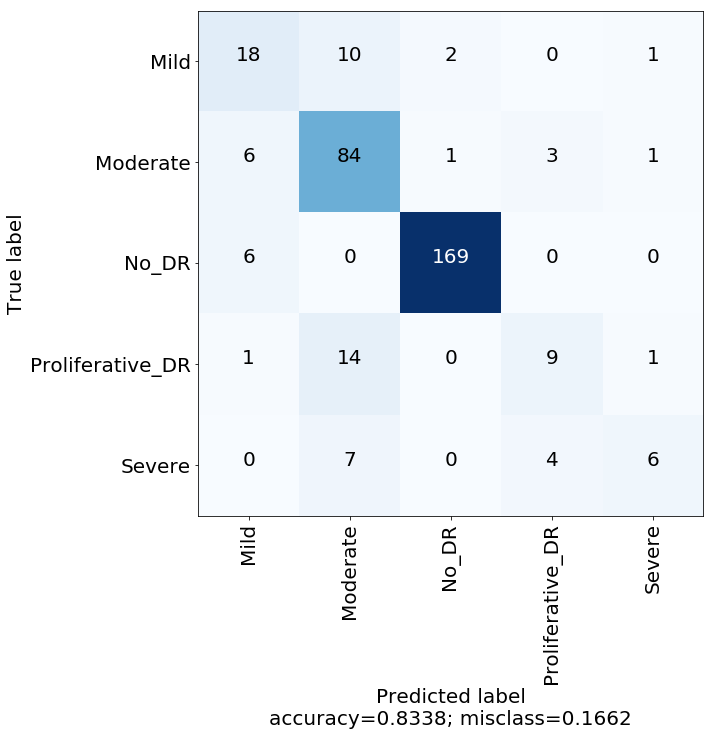

In [25]:
plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 20})

labels = []

label = test_generator.class_indices
indexlabel = dict((value, key) for key, value in label.items())

for k,v in indexlabel.items():
    labels.append(v)

from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix')

    print(cm)
#     fig = plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
#     plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
#     plt.savefig('plots/3.InceptionV3-2-Private-DataSet-CM.png', bbox_inches='tight', dpi = 100) 


plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes=labels, title=' ')

In [26]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
y_pred=predictions
y_pred_probabilities=y_pred

# y_pred = np.argmax(y_pred,axis = 1) 
y_actual = y_true

classnames=[]
for classname in test_generator.class_indices:
    classnames.append(classname)

confusion_mtx = confusion_matrix(y_actual, y_pred) 
print(confusion_mtx)
target_names = classnames
print(classification_report(y_actual, y_pred, target_names=target_names))

[[ 18  10   2   0   1]
 [  6  84   1   3   1]
 [  6   0 169   0   0]
 [  1  14   0   9   1]
 [  0   7   0   4   6]]
                  precision    recall  f1-score   support

            Mild       0.58      0.58      0.58        31
        Moderate       0.73      0.88      0.80        95
           No_DR       0.98      0.97      0.97       175
Proliferative_DR       0.56      0.36      0.44        25
          Severe       0.67      0.35      0.46        17

        accuracy                           0.83       343
       macro avg       0.70      0.63      0.65       343
    weighted avg       0.83      0.83      0.83       343



In [27]:
cohen_kappa_score(y_true, y_pred)

0.7397017707362534

In [28]:
total=sum(sum(cm))

sensitivity = cm[0,0]/(cm[0,0]+cm[1,0])
print('Sensitivity : ', sensitivity )

Specificity = cm[1,1]/(cm[1,1]+cm[0,1])
print('Specificity : ', Specificity )

Sensitivity :  0.75
Specificity :  0.8936170212765957


In [29]:
y_pred_class = model.predict(test_data, verbose=1)

y_pred_class = [np.argmax(r) for r in y_pred_class]
test_y = [np.argmax(r) for r in test_labels]


from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, cohen_kappa_score, roc_auc_score, roc_curve

# Precision
print('Precision = ', precision_score(test_y, y_pred_class, average='weighted'))
# (None, 'micro', 'macro', 'weighted', 'samples')

# Recall
print('Recall = ', recall_score(test_y, y_pred_class, average='weighted'))

# f1_score
print('f1_score = ', f1_score(test_y, y_pred_class, average='weighted'))

343/343 [==============================] - 0s 68us/step
Precision =  0.8301306475211779
Recall =  0.8338192419825073
f1_score =  0.8258975472394052


In [30]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelBinarizer

def multiclass_roc_auc_score(y_test, y_pred, average="weighted"):
    label_binarizer = LabelBinarizer()
    label_binarizer.fit(y_test)

    truth = label_binarizer.transform(y_test)
    pred = label_binarizer.transform(y_pred)
    return roc_auc_score(truth, pred, average=average)
# roc_auc_score
print('roc_auc_score = ', multiclass_roc_auc_score(test_y, y_pred_class))

roc_auc_score =  0.8921305789360541


In [ ]:
plt.rcParams.update({'font.size': 12})

import seaborn
plt.style.use('seaborn-white')

plt.figure()
N = epochs
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")

plt.legend(loc="center right")